Inspired from this [github repository](https://github.com/MadryLab/mnist_challenge/blob/master/pgd_attack.py)

In [2]:
%%capture
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import sys
import math

import matplotlib.pyplot as plt
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np

2025-12-02 14:34:16.746433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 14:34:16.746531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 14:34:16.748338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 14:34:16.759585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Attaque untargeted

In [3]:
def pgd_attack(model, loss_fn, images, labels, epsilon, a, k):  
    x = images + np.random.uniform(-epsilon, epsilon, images.shape)
    x = np.clip(x, 0, 1) # verifier que la randomisation n'a pas fait sortir les pixels de [0, 1]

    for i in range(k):
      # convertir les donnes en donnes facilement manipulables par tf
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      y_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
      
      # pareil que FGSM
      with tf.GradientTape() as tape:
        tape.watch(x)
        outputs = model(x)
        loss = loss_fn(y_tensor, outputs)
      
      grad = tape.gradient(loss, x).numpy()

      x = x.numpy()
      x += a * np.sign(grad) # avancer d'un petit pas, ici a = 0.01, tandis qu'avec fgsm, on avancait d'un seul coup, d'un facteur epsilon 
                                  # for img_idx in range(len(x)): x[img_idx] += self.a * np.sign(grad[img_idx]) # cache ce type de boucle
      # normaliser les donnees
      x = np.clip(x, images - epsilon, images + epsilon)
      x = np.clip(x, 0, 1)

    return x

In [4]:
model = tf.keras.models.load_model('/work/mnist_classifier_model.keras')
loss_fn = tf.keras.losses.CategoricalCrossentropy()

2025-12-02 14:34:23.019990: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


In [5]:
(_, _), (x_batch, y_batch) = tf.keras.datasets.mnist.load_data()
x_batch = x_batch.astype('float32') / 255.0
y_batch = to_categorical(y_batch, 10)
# utilise plus loin, pour l'affichage du graphique 
batch_size=32
normal_loader = tf.data.Dataset.from_tensor_slices((x_batch, y_batch)).batch(batch_size)

Prendre les chiffres dans l'ordre

In [6]:
xx_batch = np.array([x_batch[10], x_batch[2], x_batch[1], x_batch[32], x_batch[4], x_batch[15], x_batch[21], x_batch[0], x_batch[61], x_batch[9]])
yy_batch = np.array([y_batch[10], y_batch[2], y_batch[1], y_batch[32], y_batch[4], y_batch[15], y_batch[21], y_batch[0], y_batch[61], y_batch[9]])
x_adv = pgd_attack(model, loss_fn, xx_batch, yy_batch, 0.2, 0.01, 40)

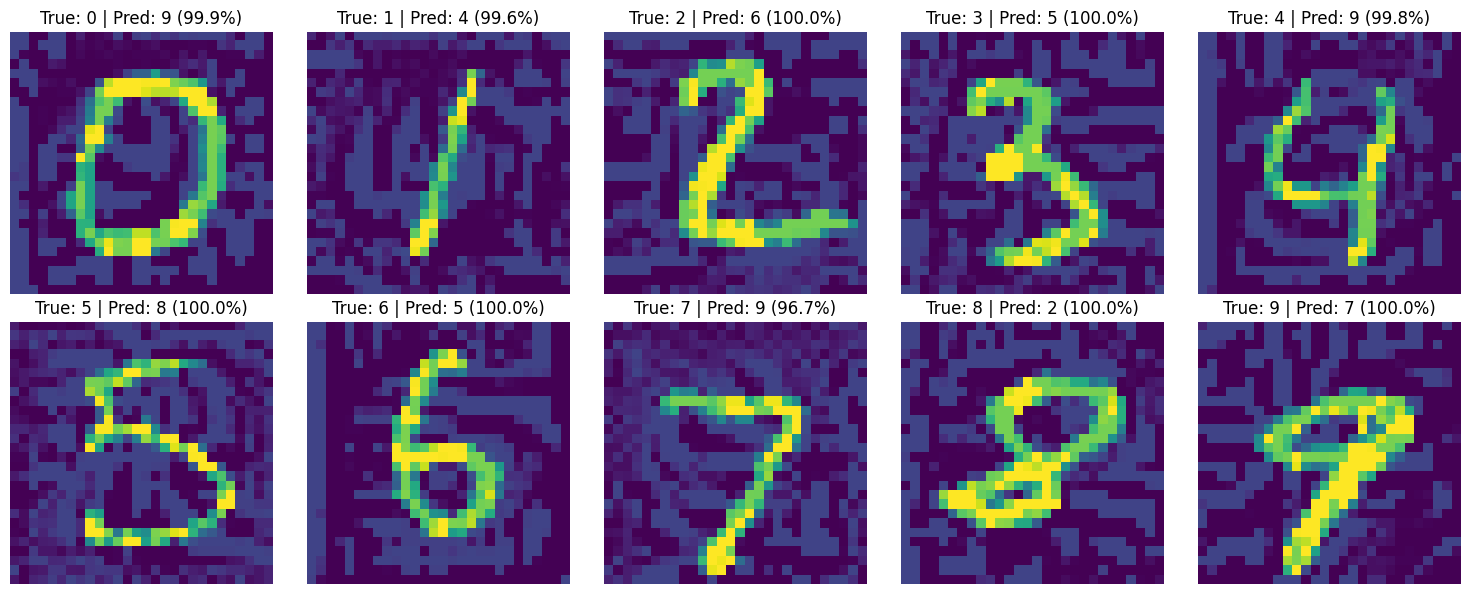

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    x_adv_image = x_adv[i].reshape(28, 28)
    
    x_adv_tensor = tf.convert_to_tensor(x_adv[i].reshape(1, 28, 28, 1), dtype=tf.float32)
    prediction = model(x_adv_tensor)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100
    
    axes[i].imshow(x_adv_image)
    axes[i].set_title(f'True: {np.argmax(yy_batch[i])} | Pred: {predicted_class} ({confidence:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

chronométrer

In [8]:
img = xx_batch[0].reshape(1,28,28)
lab = yy_batch[0].reshape(1,10)
%timeit pgd_attack(model, loss_fn, img, lab, .2,.01,40)

735 ms ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Création de graphiques

(commenté car cela prend longtemps à s'exécuter)

In [9]:
"""
epsilon_vals=[]
accuracy=[]
for epsilon in range(0,20,1):
    
    print(epsilon, end=" ", flush=True)
    
    total=0
    correct=0
    
    for images, labels in normal_loader:
    
        attack_images = pgd_attack(model, loss_fn, images, labels, epsilon/100, 0.01, 40)
        outputs = model(attack_images)
        
        predictions = np.argmax(outputs, axis=1)
        
        total += len(labels)
        correct += np.sum(predictions == np.argmax(labels, axis=1))

    epsilon_vals.append(epsilon/100)
    accuracy.append(100 - 100*correct/total)
"""

'\nepsilon_vals=[]\naccuracy=[]\nfor epsilon in range(0,20,1):\n    \n    print(epsilon, end=" ", flush=True)\n    \n    total=0\n    correct=0\n    \n    for images, labels in normal_loader:\n    \n        attack_images = pgd_attack(model, loss_fn, images, labels, epsilon/100, 0.01, 40)\n        outputs = model(attack_images)\n        \n        predictions = np.argmax(outputs, axis=1)\n        \n        total += len(labels)\n        correct += np.sum(predictions == np.argmax(labels, axis=1))\n\n    epsilon_vals.append(epsilon/100)\n    accuracy.append(100 - 100*correct/total)\n'

In [10]:
"""
print(accuracy)
print(len(accuracy))
"""

'\nprint(accuracy)\nprint(len(accuracy))\n'

[2.9599999999999937, 4.890000000000001, 8.0, 12.329999999999998, 18.53, 27.450000000000003, 39.25, 51.9, 63.52, 73.14, 80.94, 86.99, 91.86, 94.78, 96.86, 97.97, 98.92, 99.27, 99.52, 99.72]


In [11]:
"""
plt.figure(figsize=(12, 6))
plt.plot(epsilon_vals, accuracy)
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
"""

'\nplt.figure(figsize=(12, 6))\nplt.plot(epsilon_vals, accuracy)\nplt.title("Précision en fonction d\'ε")\nplt.xlabel("ε")\nplt.ylabel("Précision %")\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()\n'

fixons epsilon to 0.165, puis .10

In [12]:
"""
epsilon = 0.05

accuracy=[]
for k in range(2, 50, 1):
    
    print(k, end=" ", flush=True)
    
    total=0
    correct=0
    
    for images, labels in normal_loader:
    
        attack_images = pgd_attack(model, loss_fn, images, labels, epsilon, 0.01, k)
        outputs = model(attack_images)
        
        predictions = np.argmax(outputs, axis=1)
        
        total += len(labels)
        correct += np.sum(predictions == np.argmax(labels, axis=1))

    accuracy.append(100 - 100*correct/total)
"""

'\nepsilon = 0.05\n\naccuracy=[]\nfor k in range(2, 50, 1):\n    \n    print(k, end=" ", flush=True)\n    \n    total=0\n    correct=0\n    \n    for images, labels in normal_loader:\n    \n        attack_images = pgd_attack(model, loss_fn, images, labels, epsilon, 0.01, k)\n        outputs = model(attack_images)\n        \n        predictions = np.argmax(outputs, axis=1)\n        \n        total += len(labels)\n        correct += np.sum(predictions == np.argmax(labels, axis=1))\n\n    accuracy.append(100 - 100*correct/total)\n'

In [13]:
accuracy = [9.939999999999998, 16.019999999999996, 23.810000000000002, 33.269999999999996, 42.63, 51.45, 59.59, 65.69, 70.78, 73.19, 74.73, 76.03999999999999, 77.03999999999999, 77.89, 78.47, 79.08, 79.51, 79.67, 79.95, 80.3, 80.15, 80.34, 80.5, 80.56, 80.44, 80.73, 80.71000000000001, 80.72, 80.65, 80.78999999999999, 80.89, 80.88, 80.88, 80.87, 80.97, 81.05, 80.91, 80.97, 80.93, 81.07, 81.16, 80.88, 80.99, 80.93, 81.08, 81.06, 80.82, 81.09]
print(accuracy)

[9.939999999999998, 16.019999999999996, 23.810000000000002, 33.269999999999996, 42.63, 51.45, 59.59, 65.69, 70.78, 73.19, 74.73, 76.03999999999999, 77.03999999999999, 77.89, 78.47, 79.08, 79.51, 79.67, 79.95, 80.3, 80.15, 80.34, 80.5, 80.56, 80.44, 80.73, 80.71000000000001, 80.72, 80.65, 80.78999999999999, 80.89, 80.88, 80.88, 80.87, 80.97, 81.05, 80.91, 80.97, 80.93, 81.07, 81.16, 80.88, 80.99, 80.93, 81.08, 81.06, 80.82, 81.09]


e = 0.10 ;; [9.939999999999998, 16.019999999999996, 23.810000000000002, 33.269999999999996, 42.63, 51.45, 59.59, 65.69, 70.78, 73.19, 74.73, 76.03999999999999, 77.03999999999999, 77.89, 78.47, 79.08, 79.51, 79.67, 79.95, 80.3, 80.15, 80.34, 80.5, 80.56, 80.44, 80.73, 80.71000000000001, 80.72, 80.65, 80.78999999999999, 80.89, 80.88, 80.88, 80.87, 80.97, 81.05, 80.91, 80.97, 80.93, 81.07, 81.16, 80.88, 80.99, 80.93, 81.08, 81.06, 80.82, 81.09]

e = 0.05 ;; 


/tmp/ipykernel_203/1687244690.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


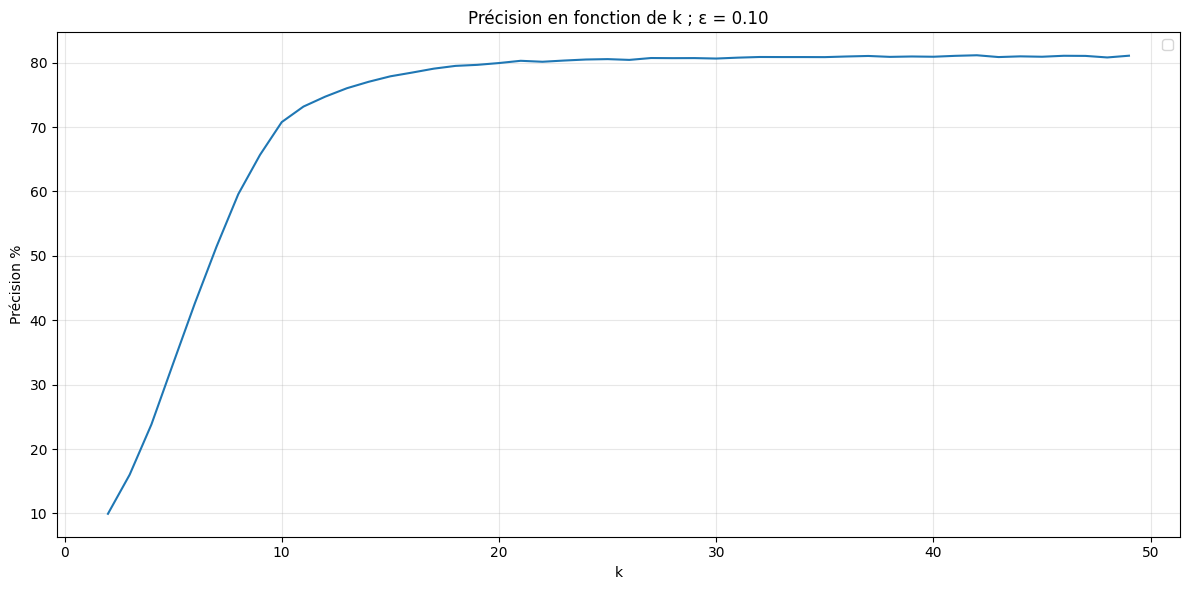

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 50, 1), accuracy)
plt.title("Précision en fonction de k ; ε = 0.10")
plt.xlabel("k")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Attaque targeted

In [15]:
def pgd_attack_targeted(model, loss_fn, images, labels, target_label, epsilon, a, k):  
    x = images + np.random.uniform(-epsilon, epsilon, images.shape)
    x = np.clip(x, 0, 1)

    for i in range(k):
      # convertir les donnes en donnes facilement manipulables par tf
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      y_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
      target_tensor = tf.convert_to_tensor(target_label, dtype=tf.float32)

      # pareil que FGSM
      with tf.GradientTape() as tape:
        tape.watch(x)
        outputs = model(x)
        loss = loss_fn(target_tensor, outputs)
      
      grad = tape.gradient(loss, x).numpy()

      x = x.numpy()
      x -= a * np.sign(grad) # avancer d'un petit pas, ici a = 0.01, tandis qu'avec fgsm, on avancait d'un seul coup, d'un facteur epsilon 
                             # for img_idx in range(len(x)): x[img_idx] += self.a * np.sign(grad[img_idx]) # cache ce type de boucle
      # normaliser les donnees
      x = np.clip(x, images - epsilon, images + epsilon) # - au lieu du +
      x = np.clip(x, 0, 1)

    return x

In [16]:
x_advs = []
target = 7
for i in range(10):

    x_test = xx_batch[i]
    x_test.resize(1, 28,28)

    y_test = yy_batch[i]
    y_target = to_categorical(target, 10)

    y_test.resize(1, 10)
    y_target.resize(1, 10)

    x_advs.append(pgd_attack_targeted(model, loss_fn, x_test, y_test, y_target, 0.2, 0.01, 40))

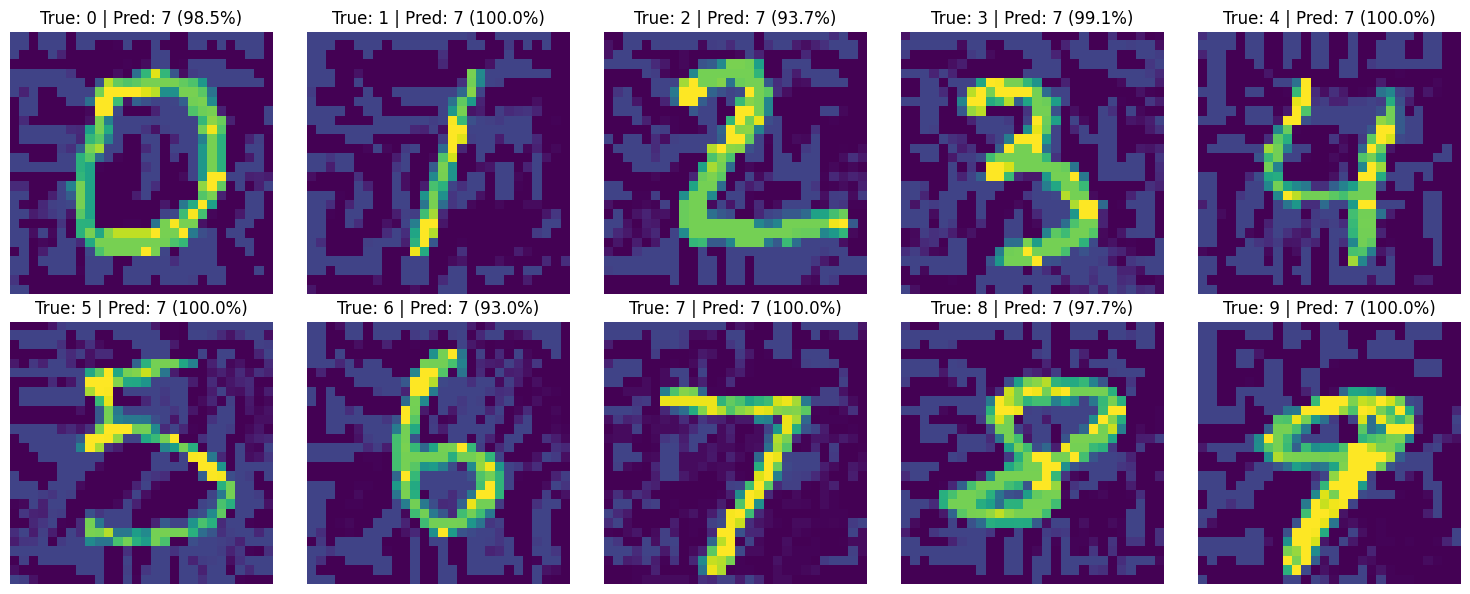

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range (10):
    
    x_adv_tensor = tf.convert_to_tensor(x_advs[i].reshape(1, 28, 28, 1), dtype=tf.float32)
    prediction = model(x_adv_tensor)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100
    
    axes[i].imshow(x_advs[i].reshape(28,28))
    axes[i].set_title(f'True: {np.argmax(yy_batch[i])} | Pred: {predicted_class} ({confidence:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## graphiques

(commenté car cela prend du temps)

In [18]:
(_, _), (x_batch, y_batch) = tf.keras.datasets.mnist.load_data()
x_batch = x_batch.astype('float32') / 255.0
y_batch = to_categorical(y_batch, 10)
# utilise plus loin, pour l'affichage du graphique 
nb_depart = 45
nb_fin    = 60
normal_loader = tf.data.Dataset.from_tensor_slices((x_batch[nb_depart:nb_fin], y_batch[nb_depart:nb_fin])).batch(1)

In [19]:
def accuracy_per_class(i, v=False): # v pour verbose
    epsilon_vals=[]
    accuracy=[]
    for epsilon in range(26):
        if v:
            print(epsilon, end=" ", flush=True)
        real_epsilon = epsilon/100

        y_target = to_categorical(i, 10)
        y_target.resize(1, 10)

        correct_targeted = 0
        total = 0

        for images, labels in normal_loader:


            attack_images = pgd_attack_targeted(model, loss_fn, images, labels, y_target, real_epsilon, 0.01, 40)
            outputs = model(attack_images)
            predictions = np.argmax(outputs, axis=1)
            
            total += len(labels)
            correct_targeted += np.sum(predictions == i)
          
            
        epsilon_vals.append(real_epsilon)
        accuracy.append(100*correct_targeted/total)
    return epsilon_vals, accuracy

In [20]:
"""
res = []
for i in range(10):
    print("\n", i, ':', end=" ")
    r = accuracy_per_class(i, v=True)
    res.append(r[1])
"""

'\nres = []\nfor i in range(10):\n    print("\n", i, \':\', end=" ")\n    r = accuracy_per_class(i, v=True)\n    res.append(r[1])\n'

In [21]:
# print(res)

In [22]:
"""
for l in res:
    print(l, ",")
"""

'\nfor l in res:\n    print(l, ",")\n'

In [23]:
l00_15 = [[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 46.666666666666664, 46.666666666666664, 53.333333333333336, 66.66666666666667, 66.66666666666667, 73.33333333333333, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 40.0, 53.333333333333336, 60.0, 60.0, 60.0, 66.66666666666667, 73.33333333333333, 80.0, 86.66666666666667, 93.33333333333333, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668, 33.333333333333336, 33.333333333333336, 46.666666666666664, 66.66666666666667, 80.0, 86.66666666666667, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 13.333333333333334, 40.0, 46.666666666666664, 60.0, 73.33333333333333, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 100.0, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 40.0, 46.666666666666664, 46.666666666666664, 46.666666666666664, 53.333333333333336, 60.0, 60.0, 73.33333333333333, 73.33333333333333, 73.33333333333333, 80.0, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 26.666666666666668, 40.0, 53.333333333333336, 80.0, 80.0, 80.0, 86.66666666666667, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 46.666666666666664, 53.333333333333336, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 26.666666666666668, 33.333333333333336, 46.666666666666664, 60.0, 60.0, 66.66666666666667, 73.33333333333333, 80.0, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 13.333333333333334, 13.333333333333334, 20.0, 26.666666666666668, 33.333333333333336, 46.666666666666664, 53.333333333333336, 66.66666666666667, 73.33333333333333, 80.0, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 40.0, 40.0, 46.666666666666664, 53.333333333333336, 60.0, 73.33333333333333, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 86.66666666666667, 86.66666666666667, 93.33333333333333]]
l15_30 = [[13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 46.666666666666664, 60.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668, 33.333333333333336, 40.0, 40.0, 60.0, 66.66666666666667, 73.33333333333333, 73.33333333333333, 80.0, 80.0, 93.33333333333333, 93.33333333333333, 93.33333333333333], [0.0, 0.0, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 20.0, 40.0, 53.333333333333336, 66.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 53.333333333333336, 73.33333333333333, 80.0, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 26.666666666666668, 33.333333333333336, 46.666666666666664, 46.666666666666664, 53.333333333333336, 60.0, 60.0, 73.33333333333333, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 33.333333333333336, 33.333333333333336, 40.0, 46.666666666666664, 53.333333333333336, 66.66666666666667, 73.33333333333333, 73.33333333333333, 80.0, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 33.333333333333336, 40.0, 53.333333333333336, 60.0, 60.0, 73.33333333333333, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 20.0, 26.666666666666668, 40.0, 40.0, 60.0, 66.66666666666667, 73.33333333333333, 86.66666666666667, 86.66666666666667, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 46.666666666666664, 60.0, 60.0, 66.66666666666667, 66.66666666666667, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 46.666666666666664, 53.333333333333336, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]]
l30_45 = [[6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668, 33.333333333333336, 40.0, 60.0, 66.66666666666667, 80.0, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0], [26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 33.333333333333336, 40.0, 46.666666666666664, 60.0, 80.0, 80.0, 80.0, 80.0, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 40.0, 46.666666666666664, 53.333333333333336, 66.66666666666667, 73.33333333333333, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 33.333333333333336, 40.0, 66.66666666666667, 66.66666666666667, 66.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 33.333333333333336, 46.666666666666664, 46.666666666666664, 46.666666666666664, 53.333333333333336, 53.333333333333336, 53.333333333333336, 60.0, 66.66666666666667, 73.33333333333333, 73.33333333333333, 80.0, 80.0, 73.33333333333333, 86.66666666666667, 93.33333333333333, 86.66666666666667], [0.0, 0.0, 0.0, 0.0, 6.666666666666667, 6.666666666666667, 20.0, 26.666666666666668, 26.666666666666668, 40.0, 53.333333333333336, 60.0, 60.0, 66.66666666666667, 80.0, 80.0, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.333333333333334, 13.333333333333334, 26.666666666666668, 33.333333333333336, 33.333333333333336, 33.333333333333336, 46.666666666666664, 60.0, 66.66666666666667, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 33.333333333333336, 33.333333333333336, 46.666666666666664, 46.666666666666664, 53.333333333333336, 60.0, 73.33333333333333, 80.0, 80.0, 86.66666666666667, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.333333333333334, 20.0, 26.666666666666668, 40.0, 40.0, 53.333333333333336, 66.66666666666667, 73.33333333333333, 86.66666666666667, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668, 40.0, 53.333333333333336, 46.666666666666664, 60.0, 73.33333333333333, 93.33333333333333, 100.0, 100.0, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 93.33333333333333]]
l45_60 = [[6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 20.0, 20.0, 20.0, 33.333333333333336, 33.333333333333336, 53.333333333333336, 60.0, 66.66666666666667, 80.0, 80.0, 86.66666666666667, 86.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 26.666666666666668, 26.666666666666668, 26.666666666666668, 40.0, 40.0, 53.333333333333336, 66.66666666666667, 73.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 13.333333333333334, 20.0, 26.666666666666668, 26.666666666666668, 33.333333333333336, 33.333333333333336, 53.333333333333336, 66.66666666666667, 80.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 13.333333333333334, 20.0, 33.333333333333336, 40.0, 53.333333333333336, 53.333333333333336, 53.333333333333336, 66.66666666666667, 73.33333333333333, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [20.0, 20.0, 20.0, 20.0, 20.0, 26.666666666666668, 26.666666666666668, 33.333333333333336, 40.0, 53.333333333333336, 53.333333333333336, 53.333333333333336, 53.333333333333336, 60.0, 73.33333333333333, 80.0, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0], [26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 26.666666666666668, 33.333333333333336, 40.0, 46.666666666666664, 53.333333333333336, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 33.333333333333336, 40.0, 46.666666666666664, 46.666666666666664, 53.333333333333336, 60.0, 73.33333333333333, 86.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 13.333333333333334, 13.333333333333334, 40.0, 46.666666666666664, 53.333333333333336, 53.333333333333336, 73.33333333333333, 86.66666666666667, 93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [0.0, 0.0, 0.0, 0.0, 6.666666666666667, 13.333333333333334, 13.333333333333334, 26.666666666666668, 33.333333333333336, 33.333333333333336, 40.0, 53.333333333333336, 66.66666666666667, 86.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [6.666666666666667, 6.666666666666667, 13.333333333333334, 13.333333333333334, 13.333333333333334, 20.0, 20.0, 26.666666666666668, 26.666666666666668, 33.333333333333336, 46.666666666666664, 46.666666666666664, 60.0, 73.33333333333333, 73.33333333333333, 80.0, 80.0, 86.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 93.33333333333333, 100.0, 93.33333333333333, 100.0, 100.0]]

l00_60 = []
for i in range(len(l00_15)):
    l00_60.append([])
    for j in range(len(l00_15[i])):
        l00_60[i].append((l00_15[i][j] + l15_30[i][j] + l30_45[i][j] + l45_60[i][j])/4)

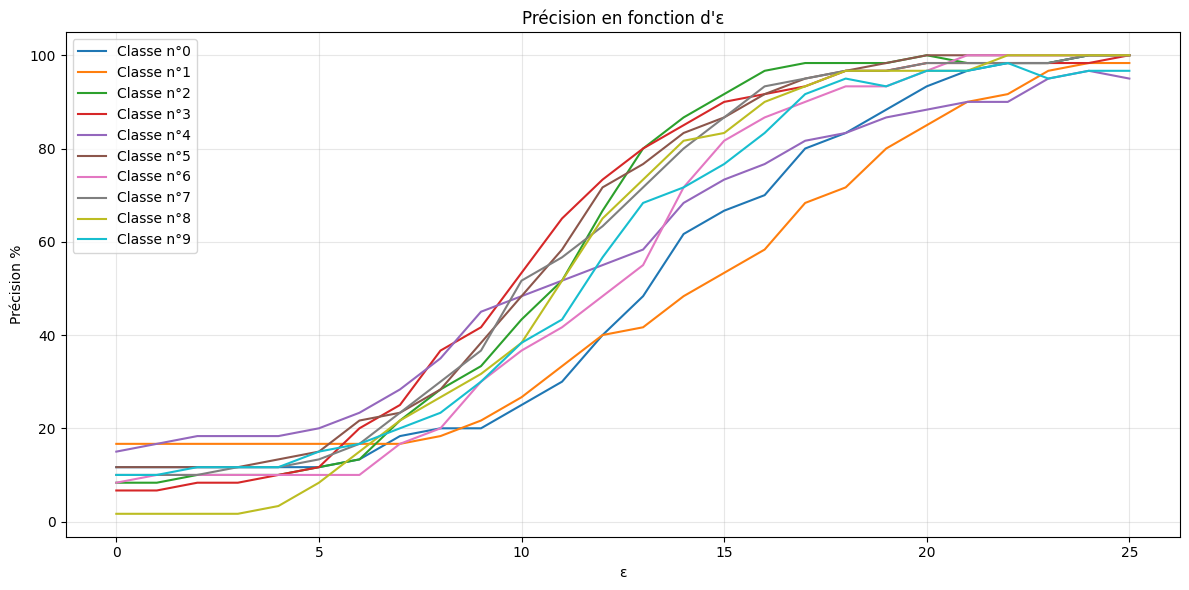

In [24]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot([i for i in range(26)], l00_60[i], label=f'Classe n°{i}')
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()